In [7]:
"""
# Linear regression California housing data

A data analysis is performed to predict the  median house value for California districts in the 1990s. 
The data is stored in `features` and `target`. `features` is a Numpy array with 20640 rows containing 
the different cases and 8 different features stored in the columns. The Numpy array `target` contains 
20640 target values for the prediction of the median house value for California districts, expressed 
in hundreds of thousands of dollars in $100,000 (MedHouseVal).

Marie Gondeck, 2021
"""

'\n# Linear regression California housing data\n\nA data analysis is performed to predict the  median house value for California districts in the 1990s. \nThe data is stored in `features` and `target`. `features` is a Numpy array with 20640 rows containing \nthe different cases and 8 different features stored in the columns. The Numpy array `target` contains \n20640 target values for the prediction of the median house value for California districts, expressed \nin hundreds of thousands of dollars in $100,000 (MedHouseVal).\n\nMarie Gondeck, 2021\n'

In [3]:
# import packages
from matplotlib import cm
import matplotlib.pylab as plt
import seaborn as sns
import math
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import r2_score

In [4]:
''' Import, understand and visualize dataset.'''
# Import datasets and get features and target arrays
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
california_housing = fetch_california_housing(as_frame=True)

# Show data set description
print(housing.DESCR)
# Show features nparray shape to get number and names of features and cases
features = housing.data
print(features.shape)
feature_names = housing.feature_names
print(feature_names)
# Show target nparray shape to check if same number of cases with features and value to predict
target = housing.target
print(target.shape)
target_names = housing.target_names
print(target_names)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

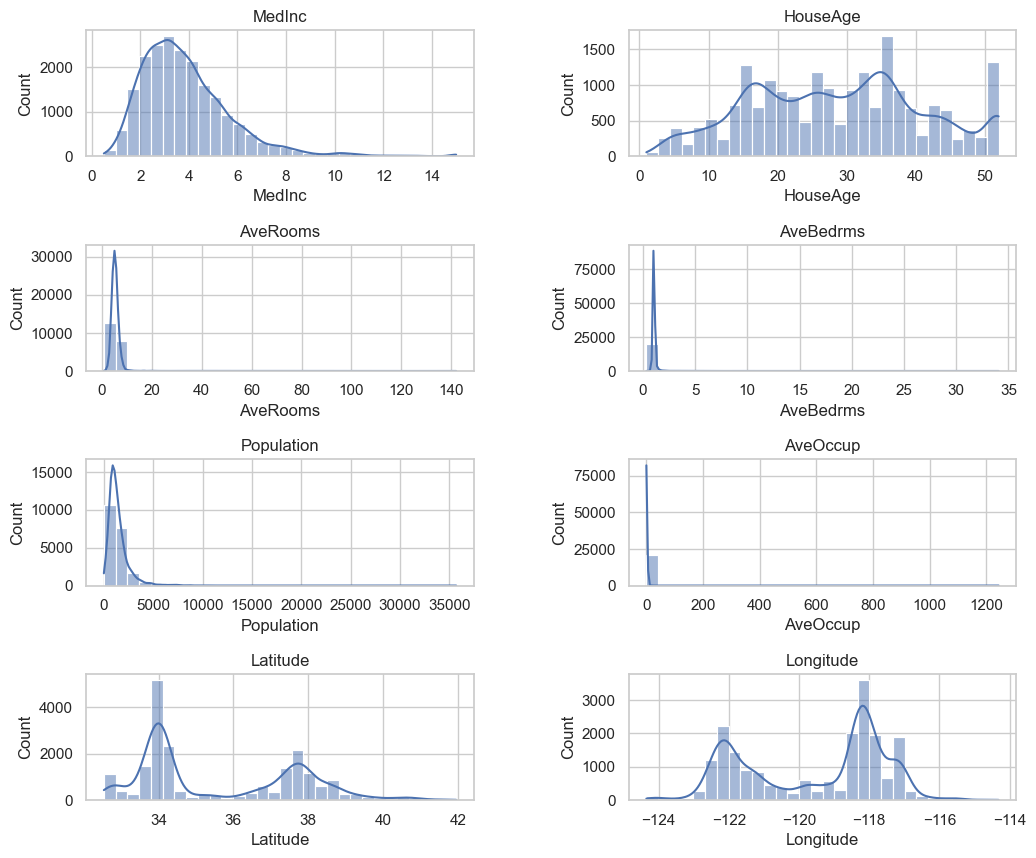

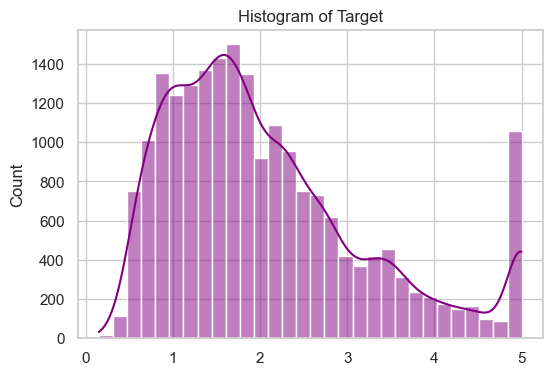

In [5]:
''' Visualize features '''

features_df = pd.DataFrame(features, columns=feature_names)
sns.set(style="whitegrid")

# Create subplots for the features
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.7, wspace=0.4)

# Loop through features and create histograms
for i, feature in enumerate(feature_names):
    ax = axes[i // 2, i % 2]
    sns.histplot(features_df[feature], bins=30, kde=True, ax=ax)
    ax.set_title(f'{feature}')

# Plot target
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(target, bins=30, kde=True, color='purple')
ax.set_title('Histogram of Target')
plt.show()

In [6]:
''' Clean and modify data'''

# check if there are any missing values
california_housing.frame.info()

# Originally, this code was based on the Boston data set, not having any negative values. However, as shown in the plot above the Longitude values are negative.
# Since the np.sqrt function is used in the updated_matrix() function and the square root of negative numbers leads to NaN values, this code was added.

# Replace all negative values in the column with their positive values.
features[:, 7] = np.abs(features[:, 7])

# Check if more negatie values exist in features
if features[features < 0].any():
    print('There are negative values in features.')
else:
    print('No negative values in features.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
No negative values in features.


In [8]:
"""
## Data preprocessing

The `Design_Matrix` class applies square and logarithm transformers to the features. The square root transformation and logarithmic scaling help stabilize variances and make data more suitable for linear regression. Feature interactions further enhance the performance of the linear regression model as the model can better capture non-linear relationships between variables. In order to later test the effects on the accuracy of the model, there are two different methods within the Design_Matrix class, that do not perform transformations and perform transformations, respectively:
  - `baseline_model`: adds a row of ones to the feature matrix to create a constant (intercept) term in the linear regression model. It allows the model to account for the baseline relationship between the features and the target.
  - `updated_matrix`: also creates a constant (intercept) term. Further performs several data transformations steps (square root and logarithmic tranfsformation with the `sklearn.preprocessing.FunctionTransformer`as well as interaction tearms between pairs of features) to stabilize variances and linearize relationships.

"""

class Design_Matrix:
    def __init__(self, features, target):
        """ Initialize a new Design Matrix instance."""
        self.features = features
        self.target = target

    def baseline_model(self):
        """ Adds a one vector row to the beginning of the feature matrix. """

        one_array = np.ones((self.features.shape[0], 1))
        baseline_model = np.hstack([one_array, self.features])

        return baseline_model

    def updated_matrix(self):
        """Applies square and log transformer, interaction terms between
        two variables and adds a one vector row to the beginning of the
        feature matrix."""

        #Square and log transformer
        transformer = FunctionTransformer(np.sqrt, np.log1p, validate = True)
        X_transformed = transformer.transform(self.features)

        #Interaction terms
        for i in range(12):
          interaction_append_function = lambda x: np.append(x, (x[:, i] * x[:, i+1])[:, None], 1)
          interaction_transformer = FunctionTransformer(func=interaction_append_function)
          X_transformed = interaction_transformer.fit_transform(X_transformed)

        #ones-vector
        one_array = np.ones((self.features.shape[0], 1))
        design_matrix = np.hstack([one_array, X_transformed])

        return design_matrix

    def feature_names(self, feature_name):
        """Converts the feature name into a number to use as an index."""

        if feature_name == 'MedInc':
          return 0
        elif feature_name == 'HouseAge':
          return 1
        elif feature_name == 'AveRooms':
          return 2
        elif feature_name == 'AveBedrms':
          return 3
        elif feature_name == 'Population':
          return 4
        elif feature_name == 'AveOccup':
          return 5
        elif feature_name == 'Latitude':
          return 6
        else:
          print('Please enter a valid feature name')

    def plot_feature(self, feature_name = None, color='b', shape='.'):
        """ Draw the specified or default feature in a plot with the target
        values, in the provided shape and color. """

        feature_name = feature_name if feature_name is not None else 'HouseAge'

        feature_number = self.feature_names(feature_name)
        selected_feature = np.transpose(self.features)[feature_number]
        plt.plot(selected_feature, self.target, color+shape)
        plt.xlabel(feature_name)
        plt.ylabel('MedHouseVal')
        plt.title("California Housing - " + feature_name + ' / ' + "MedHouseVal")

[  1.           8.3252      41.           6.98412698   1.02380952
 322.           2.55555556  37.88       122.23      ]
[  1.           2.88534227   6.40312424   2.64274989   1.01183473
  17.94435844   1.59861051   6.15467302  11.05576773  18.47520501
  16.92185588   2.67402613  18.15672511  28.68603997   9.83892496
  68.04463535 204.25757522 312.63475642  45.24948472  48.5515573
 520.8445421 ]


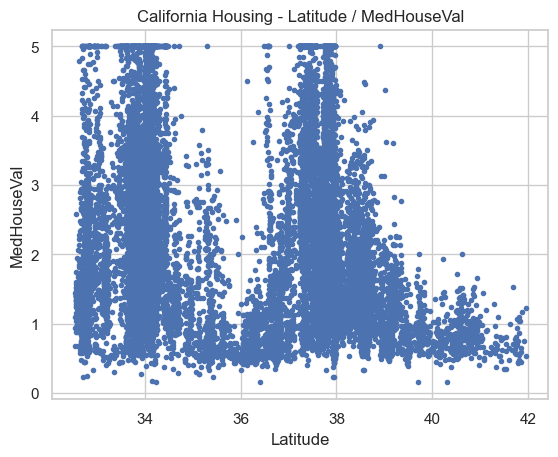

In [9]:
'''0: MedInc - median income in block group
1: HouseAge - median house age in block group
2: AveRooms - average number of rooms per household
3: AveBedrms - average number of bedrooms per household
4: Population - block group population
5: AveOccup - average number of household members
6: Latitude - block group latitude
7: Longitude - block group longitude'''

#Choose which feature to plot
chosen_feature = 'Latitude'

#Creates a Design_matrix instance for testing
california_features = Design_Matrix(features, target)

#Test if/how the data in the feature matrix changed
print(california_features.baseline_model()[0])
print(california_features.updated_matrix()[0])

#Test the plot and the feature names method
california_features.plot_feature(chosen_feature)
plt.show()

In [10]:
"""
## Linear regression and model evaluation


The `Theta` class utilizes the normal equation to perform linear regression, assuming a linear relationship between features and the target variable.

The normal equation is given below, where theta $\Theta$ is the resulting n+1 vector, X is the m x (n+1) feature matrix with n features and m cases and y is a vector with m stored target values:

$\Theta = (X^T * X)^{-1} * X^T * y$

  - `get_theta_vector`: takes a design matrix as an argument and computes the coefficients (theta values) using the normal equation. These coefficients represent the parameters that minimize the sum of squared differences between the predicted values and the actual target values in the linear regression model. In other words, it estimates the values of theta that best fit the linear relationship between the features and the target variable.
  - `predicted_values`: calculates the predicted target values based on the estimated theta coefficients and the given design matrix by solving the linear regression equation.

  $y = \Theta_0 * \Theta_1 x_1 + ... + \Theta_n x_n$

  - `coefficient_determination`: calculates the coefficient of determination $R^2$ for the two models: baseline model (without data transformations) and the best model (with data transformations) by using the built-in function `sklearn.metrics.r2_score`. R-squared is a statistical measure that quantifies the proportion of the variance in the target variable explained by the model. It indicates the goodness of the fit of the linear regression model.The best possible score is 1.0. The method returns a tuple, storing the $R^2$ values of the baseline and the best model, respectively.
  - `plot_true_pred`: creates a plot that visualizes the true target values and the best predicted values.
  - `plot_coefficient_determination_baseline` and `plot_coefficient_determination_best`: plot the predicted values against the true target values for the baseline model and the best model, respectively. The plotted lines are useful for comparing the two models in terms of $R^2$ values and how well they fit the data
"""

class Theta(Design_Matrix):
    def __init__(self, features, target):
        """ Initialize a new Theta instance. """
        Design_Matrix.__init__(self, features, target)

    def get_theta_vector(self, matrix):
        """ Solves the normal equation with a given feature matrix and
        returns a vector with the stored theta values """

        X_product_inverse = np.linalg.inv(np.dot(np.transpose(matrix), matrix))
        X_product_inverse_transpose = np.dot(X_product_inverse, np.transpose(matrix))
        theta_vector = np.dot(X_product_inverse_transpose, self.target)

        return theta_vector

    def predicted_values(self, matrix):
        """ Calculates the linear regression equation with the calculated
        theta values and a given feature matrix  """

        predicted_values = np.dot(matrix, self.get_theta_vector(matrix))

        return predicted_values

    def coefficient_determination(self):
        """ Calculates the coefficient of determination of the baseline and
        the best model. It returns both values stored in a tuple."""

        coefficient_determination_baseline = r2_score(self.target, self.predicted_values(self.baseline_model()))
        coefficient_determination_best = r2_score(self.target, self.predicted_values(self.updated_matrix()))

        return coefficient_determination_baseline, coefficient_determination_best

    def plot_true_pred(self, feature_name = None):
        """ Plots a specified or the default feature against its predicted as
        well as true target values."""

        feature_name = feature_name if feature_name is not None else 'HouseAge'

        fig, ax = plt.subplots()
        ax.plot(np.transpose(self.features)[self.feature_names(feature_name)], self.predicted_values(self.updated_matrix()), 'b'+'.', label='Predicted Values')
        ax.plot(np.transpose(self.features)[self.feature_names(feature_name)], self.target, 'g'+'.', label='True Values')

        legend = ax.legend(loc='upper right', shadow=True)
        plt.xlabel(feature_name)
        plt.ylabel('Target Value / Predicted Value')
        plt.title(feature_name +": true and predicted value")

    def plot_coefficient_determination_baseline(self):
        """ Plots the predicted values based on the baseline_model
        matrix against the true target values."""

        plt.plot(self.predicted_values(self.baseline_model()), self.target, 'b'+'.')
        plt.plot([0,9], [0,9])
        plt.xlabel('Baseline Predicted Values')
        plt.ylabel('Target Values')

    def plot_coefficient_determination_best(self):
        """ Plots the predicted values based on the updated_matrix, with
        the preprocessed data, against the true target values."""

        plt.plot(self.predicted_values(self.updated_matrix()), self.target, 'b'+'.')
        plt.plot([0,9], [0,9])
        plt.xlabel('Best Predicted Values')
        plt.ylabel('Target Values')

(0.6062326851998051, 0.6517325140556188)


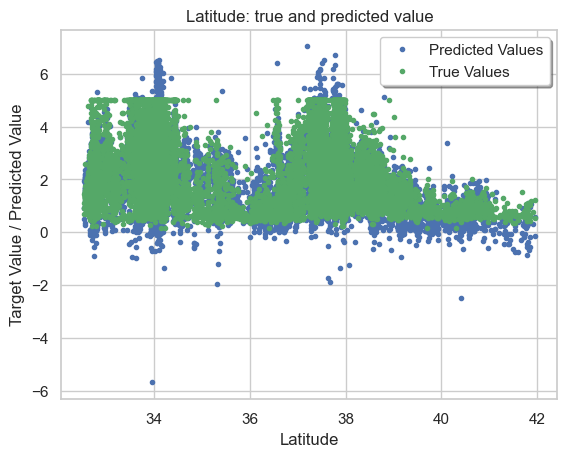

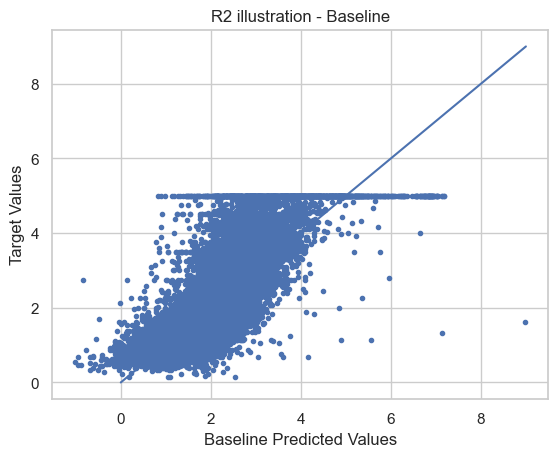

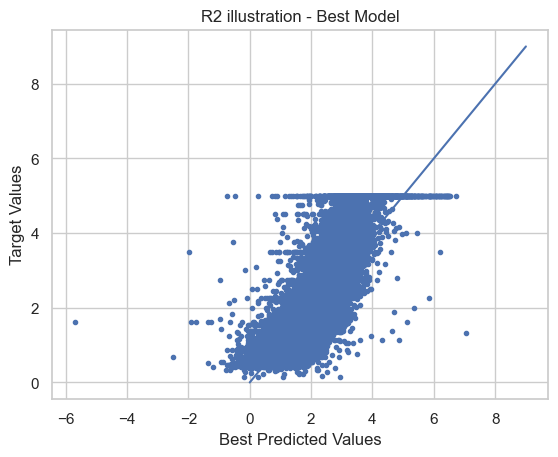

In [11]:
#Creates a Theta instance for testing
california_theta = Theta(features, target)

#The difference between the first and second value shows how much
#the model could be improved by preprocessing the data.
print(california_theta.coefficient_determination())

#Test the plot feature against predicted/true target values
california_theta.plot_true_pred(chosen_feature)
plt.show()

#Test the plot for the illustration of the coefficient of
#dertermination for the baseline model''
california_theta.plot_coefficient_determination_baseline()
plt.title("R2 illustration - Baseline")
plt.show()

#Test the plot for the illustration of the coefficient of
#dertermination for the best model
california_theta.plot_coefficient_determination_best()
plt.title("R2 illustration - Best Model")
plt.show()
